# Random Metric Space Experiment


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import itertools


# Generate a random graph

Let's pick a random graph and get the distance matrix for it

In [55]:
n, num_edges = 10, 20
# get a connected graph
G = nx.gnm_random_graph(n, num_edges)
while not nx.is_connected(G):
    G = nx.gnm_random_graph(n, num_edges)

D = nx.floyd_warshall_numpy(G)
    

In [56]:
for d in G.adjacency():
    print(d)

(0, {1: {}})
(1, {3: {}, 7: {}, 9: {}, 5: {}, 0: {}, 2: {}})
(2, {3: {}, 9: {}, 1: {}})
(3, {1: {}, 4: {}, 7: {}, 6: {}, 2: {}, 8: {}})
(4, {3: {}, 5: {}, 7: {}})
(5, {9: {}, 6: {}, 1: {}, 4: {}})
(6, {5: {}, 3: {}, 7: {}})
(7, {1: {}, 9: {}, 8: {}, 3: {}, 4: {}, 6: {}})
(8, {7: {}, 9: {}, 3: {}})
(9, {5: {}, 7: {}, 1: {}, 8: {}, 2: {}})


In [57]:
D

array([[0., 1., 2., 2., 3., 2., 3., 2., 3., 2.],
       [1., 0., 1., 1., 2., 1., 2., 1., 2., 1.],
       [2., 1., 0., 1., 2., 2., 2., 2., 2., 1.],
       [2., 1., 1., 0., 1., 2., 1., 1., 1., 2.],
       [3., 2., 2., 1., 0., 1., 2., 1., 2., 2.],
       [2., 1., 2., 2., 1., 0., 1., 2., 2., 1.],
       [3., 2., 2., 1., 2., 1., 0., 1., 2., 2.],
       [2., 1., 2., 1., 1., 2., 1., 0., 1., 1.],
       [3., 2., 2., 1., 2., 2., 2., 1., 0., 1.],
       [2., 1., 1., 2., 2., 1., 2., 1., 1., 0.]])

# Utilities for model

Next some brute-force utilities that give us the probabilities for a model 

In [58]:
def get_partition_function(D, theta, center):
    tot = 0.0
    for i in range(D.shape[0]):
        tot += np.exp(-theta*D[center, i])
    return tot

def prob(center, x, Z, theta):
    return np.exp(-theta*D[center, x])/Z

def get_weighted_center(points, weights, D):
    mindist = 10**10
    curridx = -1
    
    for i in range(D.shape[0]):
        currdist = 0.0
        for point, weight in zip(points, weights):
            currdist += weight * D[point, i]**2
        if currdist <= mindist:
            curridx = i
            mindist = currdist
    
    return curridx



Debugging to make sure everything works: compute partition function, show that the probabilities are well-defined, see if we recover the correct central node

In [59]:
theta = 2.0
Z = get_partition_function(D, theta, 0)
print(f"Probability of seeing node 0 when node 0 is the center is {prob(0,0,Z, theta)}")

t = 0.0
for i in range(n):
    t += prob(0, i, Z, theta)
print(f"This should be 1 {t}")

get_weighted_center(np.array(range(n)), np.ones(n), D)

Probability of seeing node 0 when node 0 is the center is 0.8101431646840221
This should be 1 1.0


7

In [60]:
print(np.sum(D, axis=0))

[20. 12. 15. 12. 16. 14. 16. 12. 16. 13.]


In [61]:
def ws_loop_mv(n, m, thetas, D):
    # pick a random y:
    y = np.random.randint(0, n)

    # generate the LFs:
    Zy = get_partition_function(D, theta, y)
    lfs = np.zeros(m)
    for j in range(m):
        probs = np.zeros(n)
        for k in range(n):
            probs[k] = prob(y, k, Zy, thetas[j])
        # since sometimes this is 0.999 
        probs /= np.sum(probs)

        lfs[j] = np.random.choice(n, 1, p=probs)

    lfs = lfs.astype(int)
    # recover from the LFs
    yhat = get_weighted_center(lfs, np.ones(m), D)

    if y == yhat:
        return 1
    
    return 0

def estimate_thetas(distab, distac, distbc):
    return 2.0 / (distab + distac - distbc)

def ws_loop_full(n, m, thetas, D, samples):
    # generate the data first:
    ys, yhat, yhat_mv = np.zeros(samples).astype(int), np.zeros(samples), np.zeros(samples)
    lfs = np.zeros((samples, m))
    corr, corr_mv = 0, 0

    for i in range(samples):
        ys[i] = np.random.randint(0, n)

        # generate the LFs:
        Zy = get_partition_function(D, theta, ys[i])
        for j in range(m):
            probs = np.zeros(n)
            for k in range(n):
                probs[k] = prob(ys[i], k, Zy, thetas[j])
            # since sometimes this is 0.999 
            probs /= np.sum(probs)

            lfs[i, j] = np.random.choice(n, 1, p=probs)

    lfs = lfs.astype(int)

    # learn label model
    theta_hat = np.zeros(m)
    dists_true = np.zeros(m)
    triplet_runs = 5 # probably should change this
    for j in range(m):
        lf_indices = list(range(m))
        lf_indices.remove(j)    
        triplets = list(itertools.combinations(lf_indices, 2))
        theta_est = np.zeros(triplet_runs)

        # true distance to y:
        for i in range(samples):
            dists_true[j] += D[lfs[i, j], ys[i]]
                
        for run in range(triplet_runs):
            b, c = triplets[run]
            dab, dac, dbc = 0.0, 0.0, 0.0
            for i in range(samples):
                dab += D[lfs[i, j], lfs[i, b]]
                dac += D[lfs[i, j], lfs[i, c]]
                dbc += D[lfs[i, b], lfs[i, c]]
            dab /= samples
            dac /= samples
            dbc /= samples
            theta_est[run] += estimate_thetas(dab, dac, dbc)
        theta_hat[j] = np.median(theta_est)
    dists_true /= samples
    #print(f"true distances = {dists_true}") # DEBUG: show the true average distances    
    #print(f"theta_hat = {theta_hat}") # DEBUG: show the recovered theta parameters

    # predict based on label model or majority vote
    for i in range(samples):
        yhat_mv[i] = get_weighted_center(lfs[i, :], 1.0 * theta_hat, D)
        yhat[i] = get_weighted_center(lfs[i, :], np.ones(m), D)
        if ys[i] == yhat[i]:
            corr += 1
        if ys[i] == yhat_mv[i]:
            corr_mv += 1

    return corr/samples, corr_mv/samples


        


## Majority Vote Experiment

Now let's generate some LFs with the same distance and see what happens. 

Expected: the curve goes up as the $\theta$ paramater increases, since the LFs become higher and higher quality.

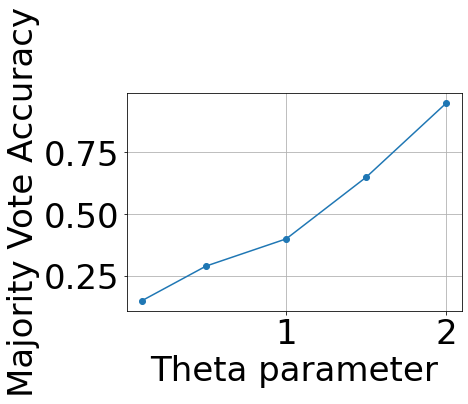

In [62]:
# 10 LFs with the same values of theta
m = 10
theta_vals = [0.1, 0.5, 1.0, 1.5, 2.0]
samples = 100

accs = np.zeros(len(theta_vals))

for theta_val, v in zip(theta_vals, list(range(len(theta_vals)))):
    thetas = theta_val * np.ones(m)
    corr = 0
    for i in range(samples):
        corr += ws_loop_mv(n, m, thetas, D)
    accs[v] = corr/samples

plt.plot(theta_vals, accs, marker='o')
plt.grid()
plt.xlabel('Theta parameter')
plt.ylabel('Majority Vote Accuracy')
plt.show()

# MV + LM Experiment
Next let's see if things change as the thetas are different. Can we make the LM better?

We'll run some alternating-quality LFs (one gets a good $\theta$, one a bad $\theta$). We also run multiple runs where the overall average $\theta$ increases, so both curves shuold go up.

In [63]:
m = 10


# a set of values of theta from very bad (highly inaccurate) to very good (highly accurate)
theta_vals = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
samples = 1000

accs_mv, accs = np.zeros(len(theta_vals)), np.zeros(len(theta_vals))
thetas_mean = []
for theta_val, v in zip(theta_vals, list(range(len(theta_vals)))):
    # this one sets alternating quality LFs
    thetas = theta_val * ((np.array(list(range(m))) % 2).astype(float) + 0.1*v)
    thetas_mean.append(np.mean(thetas))

    # this one sets equal quality LFs
    #thetas = theta_val * np.ones(m)

    #print(f"true thetas = f{thetas}") # DEBUG: check the true thetas and the relative recovery order
    accs_mv[v], accs[v] = ws_loop_full(n, m, thetas, D, samples)
    print()
    

# Heterogenous

<ipython-input-64-4619bb6130d7>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(thetas_mean, accs_mv, marker='o', markerSize=14, linewidth=4)
<ipython-input-64-4619bb6130d7>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(thetas_mean, accs, marker='x',  markerSize=14, linewidth=4)


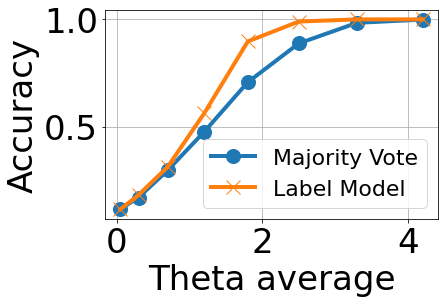

In [64]:

plt.rcParams['font.size'] = '34'
fig, ax = plt.subplots(figsize=(7, 5))


ax.plot(thetas_mean, accs_mv, marker='o', markerSize=14, linewidth=4)
ax.plot(thetas_mean, accs, marker='x',  markerSize=14, linewidth=4)
# ax.plot(theta_vals, accs_mv, marker='o', markerSize=14, linewidth=4)
# ax.plot(theta_vals, accs, marker='x',  markerSize=14, linewidth=4)
ax.legend(['Majority Vote', 'Label Model'], fontsize=22)
ax.grid()
ax.set_xlabel('Theta average') # TODO: display the average theta value here instead
ax.set_ylabel('Accuracy')
# plt.show()

root_path = '../../'
plt.tight_layout()

plt.savefig('metric_space_hetero.pdf', dpi=500, bbox_inches='tight')

# Homogenous

In [65]:
m = 10
# a set of values of theta from very bad (highly inaccurate) to very good (highly accurate)
theta_vals = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
samples = 1000

accs_mv, accs = np.zeros(len(theta_vals)), np.zeros(len(theta_vals))
thetas_mean = []
for theta_val, v in zip(theta_vals, list(range(len(theta_vals)))):
    # this one sets alternating quality LFs
#     thetas = theta_val * ((np.array(list(range(m))) % 2).astype(float) + 0.1*v)

#     this one sets equal quality LFs
    thetas = theta_val * np.ones(m)
    thetas_mean.append(np.mean(thetas))

    #print(f"true thetas = f{thetas}") # DEBUG: check the true thetas and the relative recovery order
    accs_mv[v], accs[v] = ws_loop_full(n, m, thetas, D, samples)
    print()
    

<ipython-input-66-799e1a097a5e>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(thetas_mean, accs_mv, marker='o', markerSize=14, linewidth=4)
<ipython-input-66-799e1a097a5e>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(thetas_mean, accs, marker='x',  markerSize=14, linewidth=4)


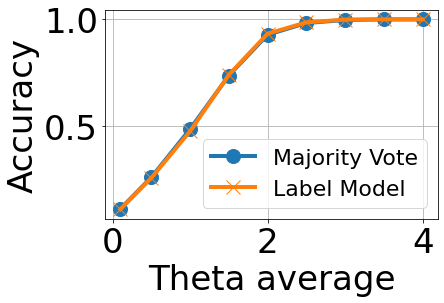

In [66]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.rcParams['font.size'] = '34'
ax.plot(thetas_mean, accs_mv, marker='o', markerSize=14, linewidth=4)
ax.plot(thetas_mean, accs, marker='x',  markerSize=14, linewidth=4)
# plt.plot(theta_vals, accs_mv, marker='o', markerSize=14, linewidth=4)
# plt.plot(theta_vals, accs, marker='x', markerSize=14, linewidth=4)
ax.legend(['Majority Vote', 'Label Model'], fontsize=22)
ax.grid()
ax.set_xlabel('Theta average') # TODO: display the average theta value here instead
ax.set_ylabel('Accuracy')
# plt.show()



root_path = '../../'
plt.tight_layout()
plt.savefig(os.path.join('metric_space_homo.pdf'),dpi=500, bbox_inches='tight')